In [1]:
import os
import sys
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import glob
import csv
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Display plots inside the notebook:
%matplotlib inline 

In [34]:
"""-------------------------------- MISCELLANEOUS FUNCTIONS -------------------------------------"""

# Plot a single color image
def plot_side_by_side(left_image, right_image, left_title='', right_title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    ax1.set_title(left_title, fontsize=30)
    ax1.imshow(left_image)    
    ax2.set_title(right_title, fontsize=30)
    ax2.imshow(right_image)

# Plot two grayscaled images side-by-side
def plot_side_by_side_gray(left_image, right_image, left_title='', right_title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    ax1.set_title(left_title, fontsize=30)
    ax1.imshow(left_image, cmap='gray')    
    ax2.set_title(right_title, fontsize=30)
    ax2.imshow(right_image, cmap='gray')    
    
# Read in images from folder:
def get_images_from_folder(folder_name='camera_cal'):
    cwd = os.getcwd()
    path = '{}/{}/{}'.format(cwd, folder_name, 'calibration*.jpg')
    image_paths = glob.glob(path)
    images = []
    for image_path in image_paths:
        image = mpimg.imread(image_path)
        images.append(image)
    return images


"""---------------------------------- CAMERA CALIBRATION ------------------------------------------"""

# Calibrate camera: 
# NOTES: board size = (# horizontal squares, # vertical squares)
def calibrate_camera(folder_in='camera_cal', folder_out='camera_cal_output', board_size=(7,10)):
    print('Calibrating', end='')
    nx = board_size[1]-1 # num vertical lines on the chessboard
    ny = board_size[0]-1 # num horizontal lines on the chessboard
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(m,n,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('{}/calibration*.jpg'.format(folder_in))

    # Count the number of images for which corners were found
    num_found = 0
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        print('.', end='')
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            num_found += 1
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            
            # Save images with found corners to file and display a sample image
            write_name = 'camera_cal_output/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #plt.imshow(img)
             
    # Get image size
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    calibration_data = dict()
    calibration_data["mtx"] = mtx
    calibration_data["dist"] = dist
    calibration_data["board_size"] = board_size
    pickle.dump(calibration_data, open("calibration_data.p", "wb" ) )
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    if num_found >= 1:
        print('\nCalibration successful!')
        print('\nChessboard corners were found on {} of {} images.\n'.format(num_found,len(images)))        
    else:
        print('\nCalibration failed because it could not find any chessboard corners.\n') 
    #return mtx, dist
    

"""---------------------------------- IMAGE PIPELINE ------------------------------------------"""

# STEP 1: Undistort image
def undistort(img, mtx, dist, display_results=False):

    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image


# STEP 2: Warp Image.  
def trapezoid_overlay(img, vertices, thickness=2):
    original_img = np.copy(img)
    trapezoid_img = cv2.polylines(original_img, [vertices.astype('int32')], True, (50,205,50), thickness)
    return trapezoid_img


def warp(img, src, dst):
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio

    # Get the image shape (width (pos-right), height (pos-down))
    img_size = (img_w, img_h)
   
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #Minv = cv2.getPerspectiveTransform(dst, src)   
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)   
    
    return warped


# STEP 3: Create a color and Sobel threshold image
def color_and_gradient_mask(img):
    
    # REMOVE
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Convert to HLS color space and separate the S channel
    hls_s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    # Threshold 'hls_s' color channel
    hls_s_thresh_min = 180 #100
    hls_s_thresh_max = 255 #255 
    hls_s_binary = np.zeros_like(hls_s_channel)
    hls_s_binary[(hls_s_channel >= hls_s_thresh_min) & (hls_s_channel <= hls_s_thresh_max)] = 1
    
    
    # Convert to LUV color space and separate the L channel
    luv_l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    
    # Threshold 'luv_l' color channel
    luv_l_thresh_min = 225# 225
    luv_l_thresh_max = 250# 255
    luv_l_binary = np.zeros_like(luv_l_channel)
    luv_l_binary[(luv_l_channel >= luv_l_thresh_min) & (luv_l_channel <= luv_l_thresh_max)] = 1
    
    
    # Create a grayscale image for Sobel
    gray = np.copy(hls_s_channel)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 50 #20
    thresh_max = 255 #100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    
    # Stack each channel to view their individual contributions in green and blue respectively
    # Green = HLS S-Channel component
    # Blue  = LUV L-channel component
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(hls_s_binary), hls_s_binary, luv_l_binary)) * 255

    
    # Combine the two color binary images and the Sobel-X binary image into one binary image
    combined_binary = np.zeros_like(hls_s_binary)
    combined_binary[(hls_s_binary == 1) | (luv_l_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary, hls, hls_s_channel, color_binary#, sxbinary


# STEP 4a:  Window Search
# Plot a histogram: 
def plot_histogram(histogram, histogram_title='', figure_size=(10,5)):
    plt.figure(figsize=figure_size)
    plt.title(histogram_title, fontsize=30)
    plt.plot(histogram)
        
        
# Make a histogram:
def make_histogram(binary, padding=100, display_results=False):
     # Take a histogram of the bottom half of the image
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    # Chop off any histogram values near the edge of the image 
    histogram[:padding] = 0 
    histogram[:len(histogram)-padding-1:-1] = 0   
    
    if display_results==True:
        plot_histogram(histogram, 'Histogram')
    return histogram


# Perform a histogram-based window search
def window_search(warped_binary, histogram, dfc_correction_factor=0.3, display_results=False):
    # Assuming you have created a warped binary image called "warped_binary"
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Get radius of curvature (average of left and right lines) [meters]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = (left_curverad + right_curverad)/2
    
    
    # Get offset (distance from center of vehicle to center of lane) [meters]
    # negative offset: left-of-center
    # positive offset: right-of-center
    left_line_pos = left_fitx[-1]
    right_line_pos = right_fitx[-1]
    lane_center_pos = ((right_line_pos - left_line_pos)/2) + left_line_pos
    vehicle_center_pos = warped_binary.shape[1]/2
    distance_from_center = ((vehicle_center_pos - lane_center_pos)*xm_per_pix) + dfc_correction_factor
    
    # Create black image with only lines on it
    line_fits_binary = np.zeros((warped_binary.shape[0], warped_binary.shape[1]), dtype='uint8')
    for i in range(len(ploty)):
        try:
            index = (int(ploty[i]), int(left_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
            index = (int(ploty[i]), int(right_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
        except:
            pass

    if display_results==True:
        # ONLY FOR WRITEUP VISUALIZATION
        #Visualization
        #At this point, you're done! But here is how you can visualize the result as well:
        # Generate x and y values for plotting
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure(figsize=(10,5))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.title('Window Search', fontsize=30)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return line_fits_binary, left_fit, right_fit, ploty, left_fitx, right_fitx, avg_curverad, distance_from_center, out_img


# STEP 4b:  Perform a proximity search
def proximity_search(warped_binary, left_fit, right_fit, dfc_correction_factor=0.3, display_results=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "warped_binary")
    # It's now much easier to find line pixels!
    # Create an image to draw on and an image to show the selection window
    
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
       
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Get radius of curvature (average of left and right lines)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = (left_curverad + right_curverad)/2

    # Get offset (distance from center of vehicle to center of lane) [meters]
    # negative offset: left-of-center
    # positive offset: right-of-center
    left_line_pos = left_fitx[-1]
    right_line_pos = right_fitx[-1]
    lane_center_pos = ((right_line_pos - left_line_pos)/2) + left_line_pos
    vehicle_center_pos = warped_binary.shape[1]/2
    distance_from_center = ((vehicle_center_pos - lane_center_pos)*xm_per_pix) + dfc_correction_factor
    
    # Create black image with only lines on it
    line_fits_binary = np.zeros((warped_binary.shape[0], warped_binary.shape[1]), dtype='uint8')
    for i in range(len(ploty)):
        try:
            index = (int(ploty[i]), int(left_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
            index = (int(ploty[i]), int(right_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
        except:
            pass   
    
   
    # ONLY FOR WRITEUP VISUALIZATION
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))



    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if display_results == True:
        plt.figure(figsize=(10,5))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.title('Proximity Search', fontsize=30)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return line_fits_binary, left_fit, right_fit, ploty, left_fitx, right_fitx, avg_curverad, distance_from_center, result


# # STEP 5:  Fill in the warped trapezoid
# def fill_image(line_fits_binary, display_results=False):   
        
#     filled_image = np.copy(line_fits_binary)    
#     midpoint = filled_image.shape[1]//2
#     for i, row in enumerate(filled_image):
#         start_point = np.argmax(row[:midpoint])
#         end_point = np.argmax(row[midpoint:]) + midpoint        
        
#         filled_image[i, start_point:end_point] = 255

#     if display_results==True:
#         plot_single_image_gray(filled_image, 'Filled Image')
    
#     return filled_image


# STEP 5:  Fill the warped trapezoid 
def fill_image(line_fits_binary, ploty, left_fitx, right_fitx):
    
    warped = np.copy(line_fits_binary)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    filled_image = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(filled_image, np.int_([pts]), (0,255, 0)) # <-- color will be green

    return filled_image
#     # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = unwarp(color_warp, src, dst)
#     plt.imshow(newwarp)

    # Combine the result with the original image
    #result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)






# STEP 6: Unwarp the filled in image
def unwarp(img, src, dst):
  
    # Given src and dst points, calculate the perspective transform matrix
    #M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)   
    
    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(img, Minv, img_size)   
    return unwarped


# STEP 7:  Reshape the unwarped image so that it has 3 color channels instead of 1
def reshape_unwarped(unwarped_image, display_results=False):
    reshaped_unwarped_image = np.zeros((unwarped_image.shape[0], unwarped_image.shape[1], 3), dtype='uint8')    
    # Fill shape using the green color channel
    #reshaped_unwarped[:,:,0] = unwarped[:,:]
    reshaped_unwarped_image[:,:,1] = unwarped_image[:,:]
    #reshaped_unwarped[:,:,2] = unwarped[:plt.imshow(reshaped_unwarped)   
    
    if display_results==True:
        plot_single_image(reshaped_unwarped_image, 'Reshaped Unwarped Image')
    return reshaped_unwarped_image


# STEP 8:  Combine the filled in trapezoid with the original image 
def weigh_image(reshaped_unwarped_image, original_image, α=0.8, β=1., λ=0., display_results=False):    
    weighted_image = cv2.addWeighted(original_image, α, reshaped_unwarped_image, β, λ)
    
    if display_results==True:
        img = np.copy(weighted_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plot_single_image(img, 'Weighted Image')
    
    return weighted_image


# STEP 9:   Add text overlay to weighted image
# https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html?highlight=puttext#void putText(Mat& img, const string& text, Point org, int fontFace, double fontScale, Scalar color, int thickness, int lineType, bool bottomLeftOrigin)
def text_overlay(weighted_image, avg_curverad, distance_from_center, display_results=False):
    img = np.copy(weighted_image)
    roc = str(int(avg_curverad))
    dfc = str(round(abs(distance_from_center), 3))

    if distance_from_center <= 0:
        direction = "LEFT OF CENTER"
    else:
        direction = "RIGHT OF CENTER"

    text1 = "RADIUS OF CURVATURE = {} METERS".format(roc)
    text2 = "VEHICLE IS {} METERS {}".format(dfc, direction)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    final_image = cv2.putText(img, text1, (50, 80), font, 1.4, (255, 255, 255), 2, cv2.LINE_AA)
    final_image = cv2.putText(img, text2, (50, 130), font, 1.4, (255, 255, 255), 2, cv2.LINE_AA)

    if display_results==True:
        img = np.copy(final_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
        plot_single_image(img, 'Final Image')
    
    return final_image




















# Camera Calibration

In [3]:
# Calibrate camera and store calibration data in .p file

# NOTE: This step can be skipped calibration has already been
#       performed for this camera.  The 'mtx' and 'dist' variables
#       will be read in from the 'calibration_data.p' file.

#calibrate_camera()

In [4]:
# Get camera calibration data from pickle file:
calibration_data = pickle.load( open("calibration_data.p", "rb" ) )
mtx, dist = calibration_data["mtx"], calibration_data["dist"]

# Image Pipeline

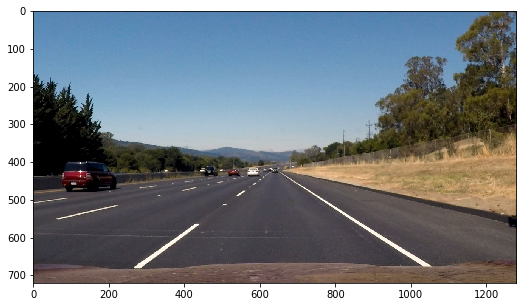

In [5]:
# STEP 0: Read in a test image
original_image = cv2.imread('test_images/straight_lines2.jpg')
original_image = gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_height = original_image.shape[0]
image_width = original_image.shape[1]
num_channels = original_image.shape[2]

# Save some useful image dimensions
img_h = original_image.shape[0]
img_w = original_image.shape[1]
y_mid = img_h//2
x_mid = img_w//2

# Plot the image
plt.figure(figsize=(10,5))
plt.imshow(original_image, cmap=None)

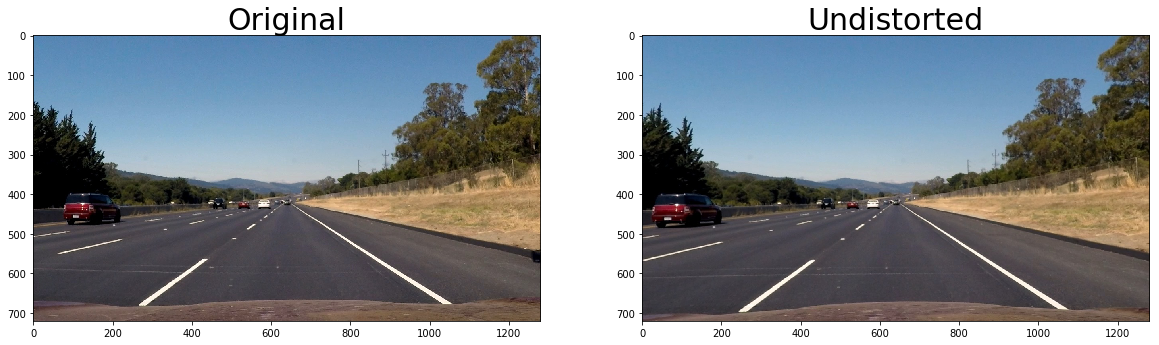

In [6]:
# STEP 1: Undistort image
undistorted_image = undistort(original_image, mtx, dist)
plot_side_by_side(original_image, undistorted_image, 'Original', 'Undistorted')

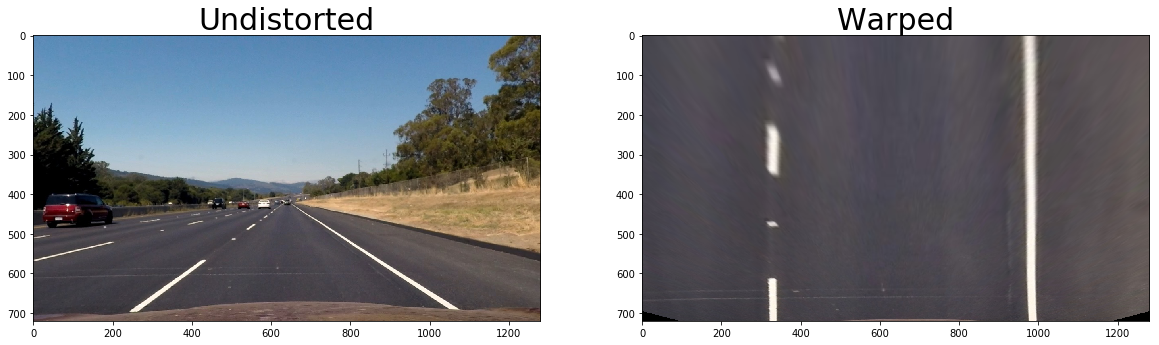

In [7]:
# STEP 2: Apply a perspective transform to ge a warped "bird's eye view" image

# Define trapezoid dimensions
trap_height = 260
trap_top_width = 170
trap_base_width = img_w-100
trap_bottom_cutoff = 40
trap_v_shift = 0   # positive --> shifts entire trapezoid UP
trap_h_shift = 0   # positive --> shifts entire trapezoid to the RIGHT

# Store 4 trapezoid vertices in 'src' (...starting with top left point going clockwise)
src = np.float32(
    [[x_mid + trap_h_shift - trap_top_width//2, img_h - trap_v_shift - trap_height],
     [x_mid + trap_h_shift + trap_top_width//2, img_h - trap_v_shift - trap_height],
     [x_mid + trap_h_shift + trap_base_width//2, img_h - trap_v_shift - trap_bottom_cutoff],
     [x_mid + trap_h_shift - trap_base_width//2, img_h - trap_v_shift - trap_bottom_cutoff]])

# The 4 points from 'src' will be mapped to these 4 points
# NOTE: 'offset' is padding added to the left and right sides of the image
top_offset = 200
base_offset = top_offset - 60
img_size = (img_w, img_h)

dst = np.float32([[top_offset, 0],
                  [img_w-top_offset, 0], 
                  [img_w-base_offset, img_h], 
                  [base_offset, img_h]])

# Warp the image
warped = warp(undistorted_image, src,dst)
plot_side_by_side_gray(undistorted_image, warped ,'Undistorted' , 'Warped')

# # STEP 2b: Apply a perspective transform to ge a warped "bird's eye view" image

# trap_height = 260
# trap_top_width = 170
# trap_base_width = img_w-400
# trap_bottom_cutoff = 40
# trap_v_shift = 0   # positive --> shifts entire trapezoid UP
# trap_h_shift = 10   # positive --> shifts entire trapezoid to the RIGHT

# # Store 4 trapezoid vertices in 'src' (...starting with top left point going clockwise)
# src = np.float32([[ 580, 460],  # Top Left Point [x, y]
#                   [ 710, 460],  # Top Right Point [x, y]
#                   [1060, 680],  # Bottom Right Point [x, y]
#                   [ 260, 680]]) # Bottom Left Point [x, y]

# # The 4 points from 'src' will be mapped to these 4 points
# # NOTE: 'offset' is padding added to the left and right sides of the image
# top_offset = 300
# base_offset = top_offset
# img_size = (img_w, img_h)

# dst = np.float32([[top_offset, 0],
#                   [img_w-top_offset, 0], 
#                   [img_w-base_offset, img_h], 
#                   [base_offset, img_h]])

# plt.imshow(trapezoid_overlay(undistorted_image, src))

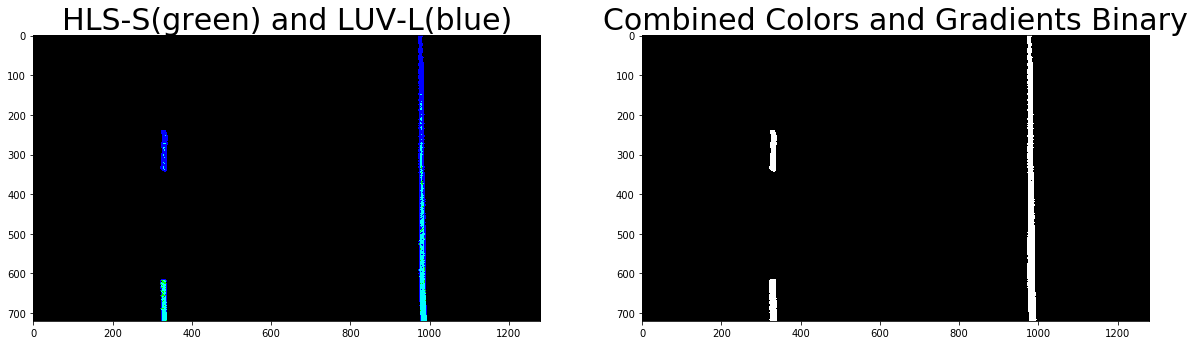

In [8]:
# STEP 3: Apply color and Sobel thresholds to create a combined_binary image
combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(warped)
plot_side_by_side_gray(color_binary, combined_binary, 'HLS-S(green) and LUV-L(blue)', 'Combined Colors and Gradients Binary')

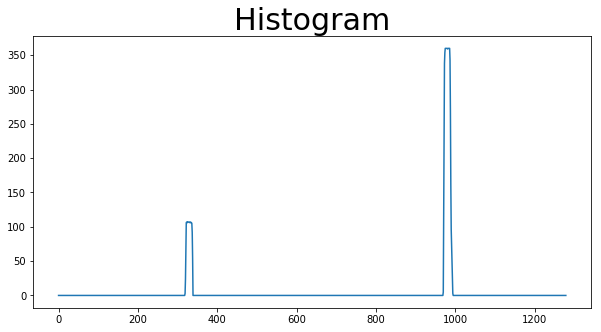

In [9]:
histogram = make_histogram(combined_binary, 200, True)

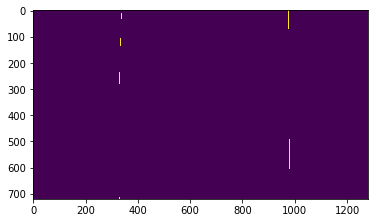

In [10]:
line_fits_binary, left_fit, right_fit, ploty, left_fitx, right_fitx, avg_curverad, distance_from_center, out_img = window_search(combined_binary, histogram, dfc_correction_factor=0.3, display_results=False)
plt.imshow(line_fits_binary)

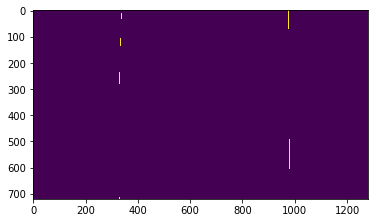

In [11]:
line_fits_binary, left_fit, right_fit, ploty, left_fitx, right_fitx, avg_curverad, distance_from_center, out_img = proximity_search(combined_binary, left_fit, right_fit, dfc_correction_factor=0.3, display_results=False)
plt.imshow(line_fits_binary)

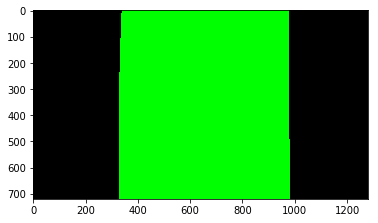

In [35]:
filled_image = fill_image(line_fits_binary, ploty, left_fitx, right_fitx)
plt.imshow(filled_image, cmap='gray')

In [36]:
# reshaped_unwarped_image = reshape_unwarped(unwarped)
# plt.imshow(reshaped_unwarped_image)

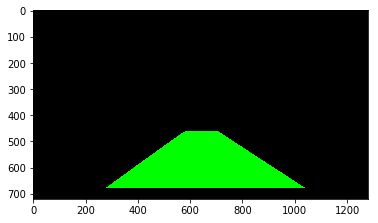

In [37]:
unwarped_image = unwarp(filled_image, src, dst)
plt.imshow(unwarped_image, cmap='gray')

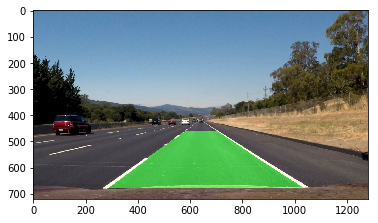

In [38]:
weighted_image = weigh_image(unwarped_image, original_image, α=1., β=.5, λ=0.)
plt.imshow(weighted_image)

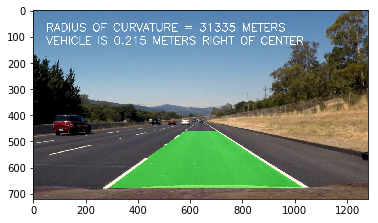

In [39]:
final_image = text_overlay(weighted_image, avg_curverad, distance_from_center)
plt.imshow(final_image)

# Process Test Images

In [40]:
def read_in_image(path_in, display_results=False):    
    original_image = cv2.imread(path_in)    
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    if display_results==True:
        plot_single_image(original_image, 'Original Image')
    return original_image

In [41]:
### Process video functions
def process_test_image(folder_in, image_name, folder_out, display_results=True):
       
    path_in = "{}/{}".format(folder_in, image_name)
    subfolder_out = image_name.split('.')[0]
     
    original_image = read_in_image(path_in, display_results=False)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '0_original_image.jpg')    
    cv2.imwrite(path, original_image)    
    
    undistorted_image = undistort(original_image, mtx, dist)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '1_undistorted_image.jpg')    
    cv2.imwrite(path, undistorted_image)    
    
    trapezoid_image = trapezoid_overlay(undistorted_image, src)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '2_trapezoid_image.jpg')    
    cv2.imwrite(path, trapezoid_image)        
    
    combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(undistorted_image)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '3_color_binary.jpg')    
    cv2.imwrite(path, color_binary)    
    
    warped = warp(combined_binary, src, dst)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '4_warped.jpg')    
    warped_save = (np.copy(warped))*255    
    cv2.imwrite(path, warped_save)    
    
    histogram = make_histogram(warped)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '5_histogram.jpg')    
    plt.figure(figsize=(10,5))
    plt.title('Histogram', fontsize=30)
    plt.plot(histogram)
    plt.savefig(path)
    plt.close()
        
    line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, window_search_image = window_search(warped, histogram, dfc_correction_factor=0.3)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '6_window_search_image.jpg')    
    cv2.imwrite(path, window_search_image)    
    
    line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, proximity_search_image = proximity_search(warped, left_fit, right_fit, dfc_correction_factor=0.3)   
    path = "{}/{}/{}".format(folder_out, subfolder_out, '7_proximity_search_image.jpg')    
    cv2.imwrite(path, proximity_search_image)    
    
    filled_image = fill_image(line_fits_binary)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '8_filled_image.jpg')    
    cv2.imwrite(path, filled_image)    
    
    unwarped_image = unwarp(filled_image, src, dst)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '9_unwarped_image.jpg')    
    cv2.imwrite(path, unwarped_image)
    
    reshaped_unwarped_image = reshape_unwarped(unwarped_image)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '10_reshaped_unwarped_image.jpg')    
    cv2.imwrite(path, reshaped_unwarped_image)
    
    weighted_image = weigh_image(reshaped_unwarped_image, original_image, α=1.0, β=0.4, λ=0.0)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '11_weighted_image.jpg')    
    cv2.imwrite(path, weighted_image)
    
    final_test_image = text_overlay(weighted_image, avg_curverad, distance_from_center)
    path = "{}/{}/{}".format(folder_out, subfolder_out, '12_final_test_image.jpg')    
    cv2.imwrite(path, final_test_image)
    
    if display_results==True:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        final_test_image = cv2.cvtColor(final_test_image, cv2.COLOR_BGR2RGB)
        
        plot_side_by_side(original_image, final_test_image, 'Original Image', 'Final Test Image')   
    
    return final_test_image


In [42]:
# # Run all test images through pipeline and save images to folder_out:
# folder_in = 'test_images'
# folder_out = 'output_images'

# # Get a list of test image names:
# image_names = os.listdir(folder_in)

# # Create output subfolders for each test image:
# for image_name in image_names:
#     subfolder_out = "{}/{}".format(folder_out, image_name.split('.')[0])
#     if not os.path.exists(subfolder_out):
#         os.makedirs(subfolder_out)
        
#     final_test_image = process_test_image(folder_in, image_name, folder_out, display_results=True)   
   


# Process Videos

In [43]:
# # Define a class to receive the characteristics of each line detection
# class Line():

#     def __init__(self):
#         # was the line detected in the last iteration?
#         self.detected = False  
#         # x values of the last n fits of the line
#         self.recent_xfitted = [] 
#         #average x values of the fitted line over the last n iterations
#         self.bestx = None     
#         #polynomial coefficients averaged over the last n iterations
#         self.best_fit = None  
#         #polynomial coefficients for the most recent fit
#         self.current_fit = [np.array([False])]  
#         #radius of curvature of the line in some units
#         self.radius_of_curvature = None 
#         #distance in meters of vehicle center from the line
#         self.line_base_pos = None 
#         #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 
#         #x values for detected line pixels
#         self.allx = None  
#         #y values for detected line pixels
#         self.ally = None
        


In [126]:
class Frame():
    
    # Maximum and Minimum allowable polynomial curve coefs
    # Polynomials are in the form: a*x^2 + bx + c --> avg_fit = [a, b, c]
    max_a = 1.0e-4
    max_b = 1.0e0
    max_c = 1.0e3
    
    # Maximum allowable CHANGE in polynomial curve coefs from previous frame to current frame
    # Polynomials are in the form: a*x^2 + bx + c --> avg_fit = [a, b, c]
    max_delta_a = 0.0001#4.0e-5
    max_delta_b = 0.01#1.0e-2
    max_delta_c = 100#1.0e2
    
    num_old_fits_retained = 10
    old_fits = []
    
    num_failed_searches = 0
    num_failed_deltas = 0
    num_frames = 0
    
    
    def __init__(self):
            
        self.line_fits_binary = np.array([False])
        self.combined_binary = np.array([False])
        # Lines are detected or not detected in current frame
        self.left_detected = False
        self.right_detected = False
        
        # If lines were detected for current frame, these are the fitted polynomial coefs for left, right, and avg
        self.left_fitx = np.array([False])
        self.right_fitx = np.array([False])
        self.ploty = np.array([False])
        self.left_fit = np.array([0,0,0], dtype='float64')
        self.right_fit = np.array([0,0,0], dtype='float64')
        self.avg_curverad = np.array([0,0,0], dtype='float64')
        self.distance_from_center = np.array([0,0,0], dtype='float64')
        
        self.left_fit_diffs = np.array([0, 0, 0], dtype='float64')
        self.right_fit_diffs = np.array([0, 0, 0], dtype='float64')
               
        
        
    
    

In [127]:

### Process video functions
def process_image(img):    

    global first_frame
    
    copied_image = np.copy(img)
    undistorted_image = undistort(copied_image, mtx, dist)

    warped = warp(undistorted_image, src, dst)  

    combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(warped)

    histogram = make_histogram(combined_binary)

    # Use window_search the first time through.  Use proximity search thereafter
    if first_frame == True:
        line_fits_binary, left_fit, right_fit, ploty, left_fitx, right_fitx, avg_curverad, distance_from_center, search_image = window_search(combined_binary, histogram, dfc_correction_factor=0.3)
        first_frame = False
        
        previous_frame.left_fitx = left_fitx
        previous_frame.right_fitx = right_fitx
        previous_frame.ploty = ploty
        previous_frame.line_fits_binary = line_fits_binary
        previous_frame.combined_binary = combined_binary
        previous_frame.left_fit = left_fit
        previous_frame.right_fit = right_fit
        previous_frame.avg_curverad = avg_curverad
        previous_frame.distance_from_center = distance_from_center
        
        current_frame.left_fitx = left_fitx
        current_frame.right_fitx = right_fitx
        current_frame.ploty = ploty
        current_frame.line_fits_binary = line_fits_binary
        current_frame.combined_binary = combined_binary
        current_frame.left_fit = left_fit
        current_frame.right_fit = right_fit
        current_frame.avg_curverad = avg_curverad
        current_frame.distance_from_center = distance_from_center
        

    else:
        current_frame.left_fit_diffs = abs(previous_frame.left_fit - current_frame.left_fit)
        current_frame.right_fit_diffs = abs(previous_frame.right_fit - current_frame.right_fit)
        
        previous_frame.line_fits_binary = current_frame.line_fits_binary
        previous_frame.combined_binary = current_frame.combined_binary
        previous_frame.left_fit = current_frame.left_fit
        previous_frame.right_fit = current_frame.right_fit
        previous_frame.avg_curverad = current_frame.avg_curverad
        previous_frame.distance_from_center = current_frame.distance_from_center
        previous_frame.left_fit_diffs = current_frame.left_fit_diffs
        previous_frame.right_fit_diffs = current_frame.right_fit_diffs
        
        line_fits_binary, left_fit, right_fit, ploty, left_fitx, right_fitx, avg_curverad, distance_from_center, search_image = proximity_search(previous_frame.combined_binary, previous_frame.left_fit, previous_frame.right_fit, dfc_correction_factor=0.3)   

#         # Check that fit coefs are within acceptable range
#         if (left_fit[0] < Frame.max_a):
#             current_frame.left_fit = left_fit
#         else:
#             Frame.num_failed_searches += 1
            
#         if (right_fit[0] < Frame.max_a):
#             current_frame.right_fit = right_fit
#         else:
#             Frame.num_failed_searches += 1
        
        # Check that difference in previous and current LEFT fits are not too large
        delta_a = current_frame.left_fit_diffs[0]
        delta_b = current_frame.left_fit_diffs[1]
        delta_c = current_frame.left_fit_diffs[2]
        if (delta_a < Frame.max_delta_a and delta_b < Frame.max_delta_b and delta_c < Frame.max_delta_c):
            current_frame.left_fit = left_fit
            current_frame.left_fitx = left_fitx
            current_frame.ploty = ploty
        else:
            Frame.num_failed_deltas += 1
        
        # Check that difference in previous and current RIGHT fits are not too large
        delta_a = current_frame.right_fit_diffs[0]
        delta_b = current_frame.right_fit_diffs[1]
        delta_c = current_frame.right_fit_diffs[2]
        if (delta_a < Frame.max_delta_a and delta_b < Frame.max_delta_b and delta_c < Frame.max_delta_c):
            current_frame.right_fit = right_fit
            current_frame.right_fitx = right_fitx
            current_frame.ploty = ploty
        else:
            Frame.num_failed_deltas += 1
        
        
        current_frame.line_fits_binary = line_fits_binary
        current_frame.combined_binary = combined_binary
        current_frame.avg_curverad = avg_curverad
        current_frame.distance_from_center = distance_from_center
        
            
    filled_image = fill_image(current_frame.line_fits_binary, ploty, left_fitx, right_fitx)

    unwarped_image = unwarp(filled_image, src, dst)

    weighted_image = weigh_image(unwarped_image, img, α=1.0, β=0.4, λ=0.0)

    final_image = text_overlay(weighted_image, avg_curverad, distance_from_center)
        
    Frame.num_frames += 1
    return final_image


In [128]:
# ### Process video functions
# def process_image_color_binary(img):    
    
#     global first_frame
    
#     copied_image = np.copy(img)
#     undistorted_image = undistort(copied_image, mtx, dist)

#     warped = warp(undistorted_image, src, dst)  

#     combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(warped)

#     return color_binary

In [129]:
# ### Process video functions
# def process_image_search(img):    

#     global first_frame
#     global left_fit
#     global right_fit
    
#     copied_image = np.copy(img)
#     undistorted_image = undistort(copied_image, mtx, dist)

#     warped = warp(undistorted_image, src, dst)  

#     combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(warped)

#     histogram = make_histogram(combined_binary)

#     # Use window_search the first time through.  Use proximity search thereafter
#     if first_frame == True:
#         line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, search_image = window_search(combined_binary, histogram, dfc_correction_factor=0.3)
#         first_frame = False
#     else:
#         line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, search_image = proximity_search(combined_binary, left_fit, right_fit, dfc_correction_factor=0.3)   

#     return search_image

In [130]:
# Produce an output video (final_image):
def make_video(video_in_name, video_out_name, function_name, start_time=None, end_time=None):
    output = video_out_name
    clip1 = VideoFileClip(video_in_name)
    
    if start_time is not None:
        clip_out = clip1.fl_image(function_name).subclip(start_time, end_time) #NOTE: this function expects color images!!
    else:
        clip_out = clip1.fl_image(function_name) #NOTE: this function expects color images!!
    
    from IPython import get_ipython
    get_ipython().magic('time clip_out.write_videofile(output, audio=False)')
    
    # Show video output
    HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(output))
    return output

In [131]:
first_frame = True
start_time = 36
end_time = 44
previous_frame = Frame()
current_frame = Frame()

In [132]:
first_frame = True
final_video = make_video('project_video.mp4','project_video_output.mp4', process_image, start_time, end_time)

print(previous_frame.left_fit)
print(current_frame.left_fit)
print(current_frame.left_fit_diffs)
print(current_frame.right_fit_diffs)
print(Frame.num_frames)
print(Frame.num_failed_deltas)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 200/201 [01:00<00:00,  3.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 8s, sys: 8.67 s, total: 1min 16s
Wall time: 1min 3s
[ 1.15692012e-04 -2.39122027e-01  4.73584277e+02]
[ 7.69020112e-05 -2.02371885e-01  4.67483321e+02]
[0. 0. 0.]
[9.78732402e-06 5.47457660e-03 1.00405656e+00]
202
170


In [ ]:
first_frame = True
search_video = make_video('project_video.mp4','project_video_output_search.mp4', process_image_search, start_time, end_time)

In [ ]:
# Green = HLS S-Channel component
# Blue  = LUV L-channel component
first_frame = True
color_binary_video = make_video('project_video.mp4','project_video_output_color_binary.mp4', process_image_color_binary, start_time, end_time)

In [ ]:
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

[ 2.81437823e-04 -3.04190007e-01  4.39076981e+02]
[ 3.49440005e-04 -3.86184650e-01  4.53274886e+02]


[0. 0. 0.]
[5.38973850e-05 4.18581075e-02 7.53578250e+00]


102


In [122]:
print(Frame.num_failed_searches)

0


82


In [ ]:
######################################################################################################################################
######################################################################################################################################
######################################################################################################################################